In [1]:
import numpy as np
import pandas as pd
import os

import tensorflow as tf
import keras
from keras.utils import image_dataset_from_directory
from keras.optimizers import Adam
from keras import Sequential, Model
from keras.layers import (
    GlobalAveragePooling2D, Flatten, Input,
    Dense, Dropout, Conv2D, Conv2DTranspose, BatchNormalization, 
    MaxPooling2D, UpSampling2D, Rescaling, Resizing)
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from IPython.display import clear_output

from datetime import datetime
import time

from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.applications.vgg16 import preprocess_input

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import random
random_seed = 5
np.random.seed(random_seed)
random.seed(random_seed)
tf.random.set_seed(random_seed)

In [3]:
class PlotLearning(Callback):
    """
    Callback to plot metrics during training
    """
    def __init__(self, showLR=False):
      self.showLR = showLR                 

    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        metric = [x for x in logs if ('val' not in x) and ('lr' not in x)]
        if self.showLR:
          metric.append('lr')
        
        f, axs = plt.subplots(1,len(metric),figsize=(10,4))
        clear_output(wait=True)
        for i,ax in enumerate(axs):
          ax.plot(range(1, epoch + 2), self.metrics[metric[i]],'o--',label=metric[i])
          try:
            ax.plot(range(1, epoch + 2), self.metrics['val_' + metric[i]], 'o--', label='val_' + metric[i])
          except:
            pass
          ax.set_xlabel('# epochs')
          ax.set_ylabel(metric[i])
          ax.legend()
          ax.grid()

        plt.tight_layout()
        plt.show()

In [4]:
def get_model_metrics(test_data, model, model_name):
    """
    Evaluates a binary classification model on test data and reports various performance metrics.
    It calculates the confusion matrix, ROC curve, and several statistical measures including accuracy, 
    sensitivity, specificity, precision, NPV (Negative Predictive Value), PLR (Positive Likelihood Ratio), 
    NLR (Negative Likelihood Ratio), and F1-score. Additionally, it identifies the best threshold for 
    classification based on the max sensitivity within a minimum required specificity.

    The function saves the confusion matrix and ROC curve plots in a local directory, and appends the 
    calculated metrics to a CSV file. This file is created if it doesn't exist, or updated if it does.

    Parameters:
    - test_data (iterable): The test dataset, typically a generator or an iterable that yields batches 
      of images and labels.
    - model (keras.Model): The trained Keras model to evaluate.
    - model_name (str): The name of the model, used for saving output files.

    No return value. The function directly prints the calculated metrics and saves the results and plots 
    to the local file system.
    """
    timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
    results_folder = 'results'
    csv_file = f'{results_folder}/model_performance.csv'
    if not os.path.exists(results_folder):
        os.makedirs(results_folder)
        
    predicted_probs = []
    true_labels = []
    for images, labels in test_data:
        predictions = model.predict(images, verbose=0)
        predicted_probs.extend(predictions.flatten())
        true_labels.extend([int(label) for label in labels])
        
    # ROC AUC
    fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs)
    roc_auc = auc(fpr, tpr)
    
    # Calculate max sensitivity where specificity is >= 1 - prevalence
    prevalence = sum(true_labels) / len(true_labels)
    
    max_sensitivity = 0
    for i in range(len(fpr)):
        specificity = 1 - fpr[i]
        if specificity >= 1 - prevalence:
            max_sensitivity = max(max_sensitivity, tpr[i])
    print(f"Max Sensitivity at Specificity >= {1 - prevalence:.2f}: {max_sensitivity:.2f}")
    
    # Confusion Matrix
    threshold_for_max_sensitivity = thresholds[np.argmax(tpr == max_sensitivity)]
    final_predicted_labels = [1 if p > threshold_for_max_sensitivity else 0 for p in predicted_probs]
    confusion_mtx = confusion_matrix(true_labels, final_predicted_labels)
    
    # Plot the confusion matrix
    f, ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(confusion_mtx, annot=True, linewidths=0.01, cmap="Purples", linecolor="gray", fmt='.1f', ax=ax)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.savefig(f'{results_folder}/{model_name}_run_{timestamp}_confusion_matrix.png')
    plt.show()
    
    # Classification report
    report = classification_report(true_labels, final_predicted_labels)
    print(report)
    
    # calculate additional metrics
    TP = sum((np.array(true_labels) == 1) & (np.array(final_predicted_labels) == 1))
    TN = sum((np.array(true_labels) == 0) & (np.array(final_predicted_labels) == 0))
    FP = sum((np.array(true_labels) == 0) & (np.array(final_predicted_labels) == 1))
    FN = sum((np.array(true_labels) == 1) & (np.array(final_predicted_labels) == 0))

    accuracy = accuracy_score(true_labels, final_predicted_labels)
    sensitivity = recall_score(true_labels, final_predicted_labels)  # recall
    specificity = TN / (TN + FP)
    precision = precision_score(true_labels, final_predicted_labels)  # PPV
    npv = TN / (TN + FN)
    plr = sensitivity / (1 - specificity)
    nlr = (1 - sensitivity) / specificity
    f1_pos_class = f1_score(true_labels, final_predicted_labels)

    # create a DataFrame and append to the CSV file
    df = pd.DataFrame({
        'Model Name': [model_name],
        f'Max Sensitivity at Specificity {1 - prevalence:.2f}': [max_sensitivity],
        'AUC': [roc_auc],
        'F1-Score Positive Class': [f1_pos_class],
        'Accuracy': [accuracy],
        'Sensitivity': [sensitivity],
        'Specificity': [specificity],
        'PPV': [precision],
        'NPV': [npv],
        'PLR': [plr],
        'NLR': [nlr]
    }).round(2) 
    
    if os.path.exists(csv_file):
        df.to_csv(csv_file, mode='a', header=False, index=False)
    else:
        df.to_csv(csv_file, index=False)

    print(df)
    
    # Plotting and saving ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.savefig(f'{results_folder}/{model_name}_run_{timestamp}_roc_curve.png')
    plt.show()

In [5]:
def build_model(base_model, transfer_learning):
    """
    Constructs a neural network model based on a specified base model and a transfer learning option.

    This function initializes a new model by setting the base model's trainable parameter according to 
    the transfer_learning flag ('Y' for non-trainable and 'N' for trainable). It modifies the input 
    layer to accommodate grayscale images and expands the single channel to three channels using a 
    Conv2D layer. The function then applies the base model and adds additional top layers for classification. 
    It returns the newly created model, which is suitable for binary classification tasks.

    Parameters:
    - base_model (keras.Model): The pre-existing model to use as the base.
    - transfer_learning (str): A flag ('Y' or 'N') indicating whether to freeze (non-trainable) or unfreeze 
      (trainable) the layers of the base model for transfer learning.

    Returns:
    - keras.Model: The constructed model ready for training.
    """
    # Set the base_model to be trainable or non-trainable
    if transfer_learning == 'Y':
        base_model.trainable = False
    elif transfer_learning == 'N':
        base_model.trainable = True
    print('base_model.trainable set to', base_model.trainable)

    # Define a new input layer for grayscale images
    input_layer = Input(shape=(224, 224, 1), name='grayscale_input')

    # Add a Conv2D layer to expand the single channel to three channels
    x = Conv2D(3, (3, 3), padding='same')(input_layer)

    # Add the rest of the model
    x = base_model(x)

    # Add own top layers for classification
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(1, activation='sigmoid')(x)

    # Create the new model
    model = Model(inputs=input_layer, outputs=outputs)

    return model

In [6]:
METRICS = [
       keras.metrics.AUC(name='auc'),
]

# Train on anterior placental images only

In [7]:
train_data = tf.keras.utils.image_dataset_from_directory(
    '/input/a-peso-11-mask-v2/cropped_train',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale',
    label_mode='binary',
    class_names=['healthy', 'unhealthy']  # Assign class 0 to healthy and class 1 to unhealthy                                              
)

val_data = tf.keras.utils.image_dataset_from_directory(
    '/input/a-peso-11-mask-v2/cropped_validation',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale',
    label_mode='binary',
    class_names=['healthy', 'unhealthy']
)

test_data = tf.keras.utils.image_dataset_from_directory(
    '/input/a-peso-11-mask-v2/cropped_test',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale',
    label_mode='binary',
    class_names=['healthy', 'unhealthy']
)

Found 381 files belonging to 2 classes.
Found 78 files belonging to 2 classes.
Found 87 files belonging to 2 classes.


In [8]:
basic_model = ''
# Definición de la red
basic_model = Sequential([
    # resizing
    Resizing(224,224, input_shape=(224, 224, 1)),
    # rescaling
    Rescaling(scale=1./255),
    # flatten
    Flatten(),
    # capa conectada
    Dense(1024, activation='relu'),
    # dropout
    Dropout(0.5),
    # capa de salida conectada
    Dense(1, activation='sigmoid')
])

In [9]:
# Compilación de la red
basic_model.compile(loss='binary_crossentropy', 
                    optimizer=Adam(learning_rate=1e-3), 
                    metrics=METRICS)

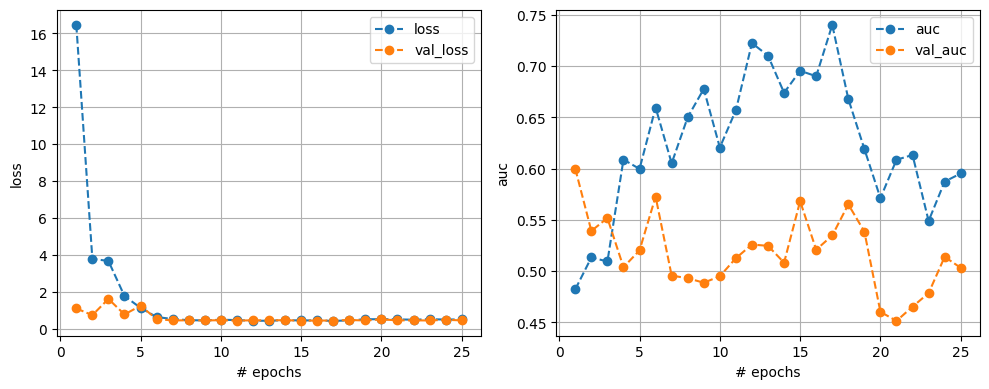

12/12 [==============================] - 2s 104ms/step - loss: 0.5048 - auc: 0.5952 - val_loss: 0.4515 - val_auc: 0.5032
Training time: 59.57232856750488 seconds


In [11]:
# Entrenamiento de la red
ann_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
ann_checkpoint = ModelCheckpoint('ann_best_weights.h5', save_best_only=True, save_weights_only=True)
ann_plot_callback = PlotLearning()

start = time.time()

history = basic_model.fit(train_data,
                    validation_data=val_data,
                    epochs=150, 
                    batch_size=32,
                    callbacks=[ann_callback, ann_checkpoint, ann_plot_callback],
                   )

end = time.time()

print('Training time:', end - start, 'seconds')

Max Sensitivity at Specificity >= 0.79: 0.28


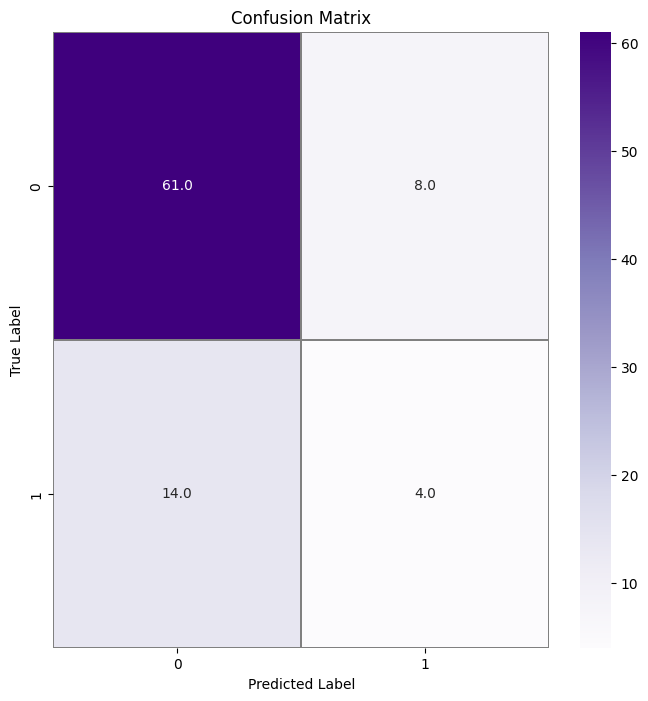

              precision    recall  f1-score   support

           0       0.81      0.88      0.85        69
           1       0.33      0.22      0.27        18

    accuracy                           0.75        87
   macro avg       0.57      0.55      0.56        87
weighted avg       0.71      0.75      0.73        87

     Model Name  Max Sensitivity at Specificity 0.79   AUC  \
0  ANN-anterior                                 0.28  0.58   

   F1-Score Positive Class  Accuracy  Sensitivity  Specificity   PPV   NPV  \
0                     0.27      0.75         0.22         0.88  0.33  0.81   

    PLR   NLR  
0  1.92  0.88  


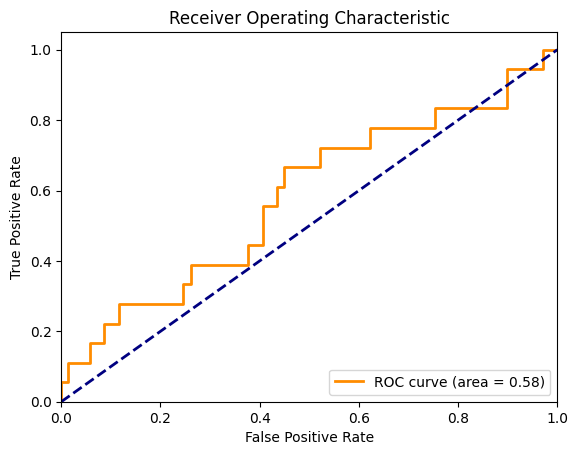

In [12]:
get_model_metrics(test_data=test_data, model=basic_model, model_name='ANN-anterior')

# Hyperparameter tuning of best model

Best model after re-training on different planes: original or anterior plane.

In [13]:
train_data = tf.keras.utils.image_dataset_from_directory(
    '/input/peso-11-mask-v2/cropped_train',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale',
    label_mode='binary',
    class_names=['healthy', 'unhealthy']  # Assign class 0 to healthy and class 1 to unhealthy                                              
)

val_data = tf.keras.utils.image_dataset_from_directory(
    '/input/peso-11-mask-v2/cropped_validation',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale',
    label_mode='binary',
    class_names=['healthy', 'unhealthy']
)

test_data = tf.keras.utils.image_dataset_from_directory(
    '/input/peso-11-mask-v2/cropped_test',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale',
    label_mode='binary',
    class_names=['healthy', 'unhealthy']
)

Found 518 files belonging to 2 classes.
Found 90 files belonging to 2 classes.
Found 453 files belonging to 2 classes.


In [14]:
# Custom metric function for optimization
def sensitivity_at_specificity(val_test, model, min_specificity):    
    predicted_probs = []
    true_labels = []
    for images, labels in val_test:
        predictions = model.predict(images, verbose=0)
        predicted_probs.extend(predictions.flatten())
        true_labels.extend([int(label) for label in labels])
        
    # ROC AUC
    fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs)
    roc_auc = auc(fpr, tpr)
    
    max_sensitivity = 0
    for i in range(len(fpr)):
        specificity = min_specificity
        if specificity >= min_specificity:
            max_sensitivity = max(max_sensitivity, tpr[i])
    
    return max_sensitivity

In [15]:
import optuna

def build_basic_model(trial):
    # Optuna: Suggest the number of neurons and dropout rate
    n_neurons = trial.suggest_int('n_neurons', 512, 2048)
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.2, 0.7)

    # Create the simpler model structure with dynamic parameters
    basic_model = Sequential([
        Resizing(224, 224, input_shape=(224, 224, 1)),
        Rescaling(scale=1./255),
        Flatten(),
        Dense(n_neurons, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])

    # Optuna: Optimize the learning rate
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-3)

    # Compile the model with the suggested hyperparameters
    basic_model.compile(loss='binary_crossentropy', 
                        optimizer=Adam(learning_rate=learning_rate), 
                        metrics=METRICS)
    return basic_model

In [24]:
def objective(trial):
    # Build the basic model with suggested hyperparameters
    model_basic = build_basic_model(trial)

    # Optuna: Suggest the batch size
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])

    # Training setup with early stopping and checkpointing
    start = time.time()
    history = model_basic.fit(train_data,
                              epochs=150,
                              batch_size=batch_size,
                              validation_data=val_data,
                              callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),
                                         tf.keras.callbacks.ModelCheckpoint('basic_best_weights.h5', save_best_only=True, save_weights_only=True),
                                         PlotLearning()]
                             )
    end = time.time()
    print('Training time:', end - start, 'seconds')

    #_, auc = model_resnet18.evaluate(prep_data, verbose=0)
    #return auc

    sensitivity = sensitivity_at_specificity(val_data, model_basic, 0.84)

    return sensitivity

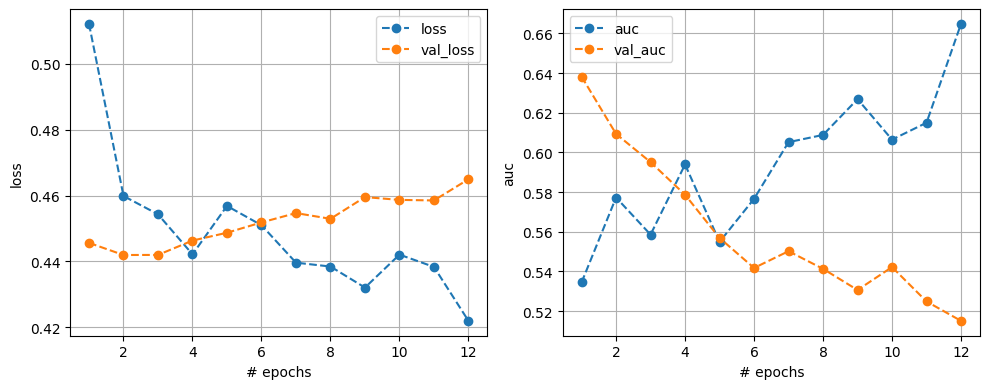

17/17 [==============================] - 2s 98ms/step - loss: 0.4219 - auc: 0.6648 - val_loss: 0.4649 - val_auc: 0.5151
Training time: 31.65780997276306 seconds


[I 2023-12-26 08:45:28,539] Trial 9 finished with value: 1.0 and parameters: {'n_neurons': 1537, 'dropout_rate': 0.4361999984839261, 'learning_rate': 1.0163860037253394e-06, 'batch_size': 64}. Best is trial 0 with value: 1.0.


Best trial: {'n_neurons': 1450, 'dropout_rate': 0.4531889110152361, 'learning_rate': 5.744958847451084e-05, 'batch_size': 32}


In [25]:
# create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# Print the best hyperparameters
print('Best trial:', study.best_trial.params)

In [26]:
best_params = study.best_trial.params
print("Best Parameters:", best_params)

Best Parameters: {'n_neurons': 1450, 'dropout_rate': 0.4531889110152361, 'learning_rate': 5.744958847451084e-05, 'batch_size': 32}


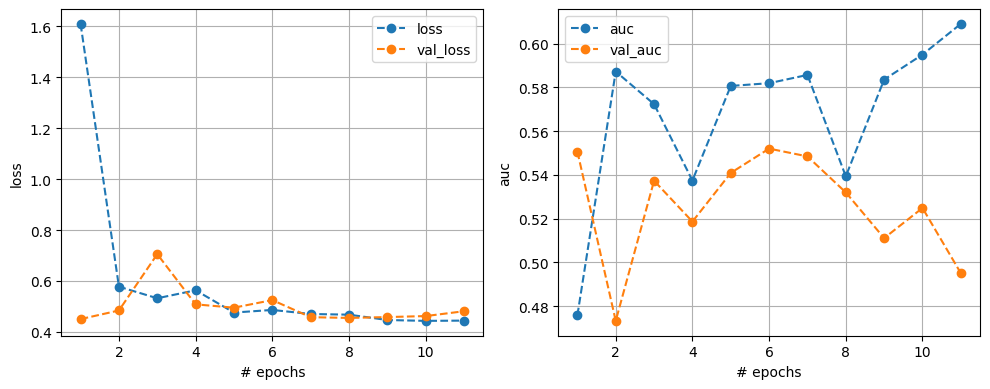

17/17 [==============================] - 3s 126ms/step - loss: 0.4442 - auc: 0.6090 - val_loss: 0.4811 - val_auc: 0.4951


In [27]:
def build_model_with_params(params):
    basic_model = Sequential([
        Resizing(224, 224, input_shape=(224, 224, 1)),
        Rescaling(scale=1./255),
        Flatten(),
        Dense(params['n_neurons'], activation='relu'),
        Dropout(params['dropout_rate']),
        Dense(1, activation='sigmoid')
    ])

    basic_model.compile(loss='binary_crossentropy', 
                        optimizer=Adam(learning_rate=params['learning_rate']), 
                        metrics=METRICS)
    return basic_model

# Use the best parameters to build the model
model_with_best_params = build_model_with_params(best_params)

# Then train the model
history = model_with_best_params.fit(train_data,
                                     epochs=150,
                                     batch_size=best_params['batch_size'],
                                     validation_data=val_data,
                                     callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),
                                                tf.keras.callbacks.ModelCheckpoint('final_best_weights.h5', save_best_only=True, save_weights_only=True),
                                                PlotLearning()])

Max Sensitivity at Specificity >= 0.84: 0.28


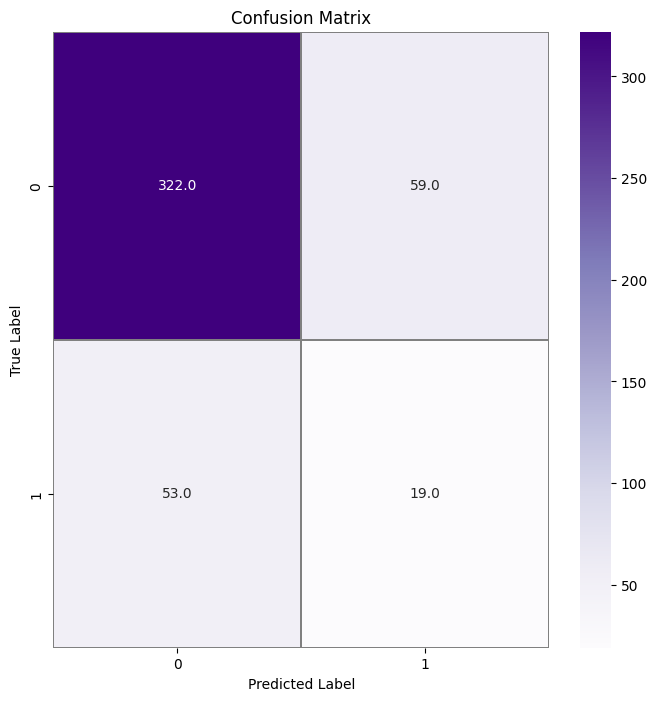

              precision    recall  f1-score   support

           0       0.86      0.85      0.85       381
           1       0.24      0.26      0.25        72

    accuracy                           0.75       453
   macro avg       0.55      0.55      0.55       453
weighted avg       0.76      0.75      0.76       453

  Model Name  Max Sensitivity at Specificity 0.84   AUC  \
0  ANN-tuned                                 0.28  0.54   

   F1-Score Positive Class  Accuracy  Sensitivity  Specificity   PPV   NPV  \
0                     0.25      0.75         0.26         0.85  0.24  0.86   

   PLR   NLR  
0  1.7  0.87  


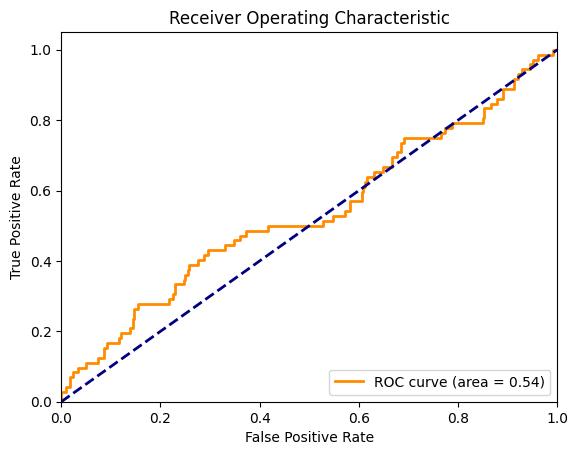

In [28]:
get_model_metrics(test_data=test_data, model=model_with_best_params, model_name='ANN-tuned')